# Data Sandbox
play ground and some example for viewing the data <br>
Content: 
* 1 Check the label file
* 2 Read the DICOM file
* 3 Normalization of box data
* 4 Data distribution for the patch data
* 5 Seperate A phase and V phase in DICOM data

## 1 Check the label file
"label.nrrd"

In [1]:
import os
import glob, ntpath
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import nrrd

In [3]:
tumor_label, tumor_options = nrrd.read('/home/d/pancreas/label_data/000136/PC38/label.nrrd')

In [6]:
tumor_options

{'dimension': 4,
 'encoding': 'gzip',
 'keyvaluepairs': {'Segment0_Color': '0.976471 0.705882 0.435294',
  'Segment0_ColorAutoGenerated': '1',
  'Segment0_Extent': '0 200 0 107 0 13',
  'Segment0_ID': 'Segment_1',
  'Segment0_Name': 'pancreas',
  'Segment0_NameAutoGenerated': '1',
  'Segment0_Tags': 'TerminologyEntry:Segmentation category and type - 3D Slicer General Anatomy list~SRT^T-D000A^Anatomical Structure~SRT^T-65000^Pancreas~^^~Anatomic codes - DICOM master list~^^~^^|',
  'Segment1_Color': '0.694118 0.478431 0.396078',
  'Segment1_ColorAutoGenerated': '1',
  'Segment1_Extent': '30 56 20 49 5 7',
  'Segment1_ID': 'Segment_3',
  'Segment1_Name': 'lesion',
  'Segment1_NameAutoGenerated': '0',
  'Segment1_Tags': 'TerminologyEntry:Segmentation category and type - 3D Slicer General Anatomy list~SRT^T-D000A^Anatomical Structure~SRT^T-65000^Pancreas~^^~Anatomic codes - DICOM master list~^^~^^|',
  'Segmentation_ContainedRepresentationNames': 'Binary labelmap|Closed surface|',
  'Segme

In [7]:
tumor_label.shape

(2, 201, 108, 14)

## 2 Read DICOM file

In [36]:
import time, random
import os, glob, ntpath
import re
import logging
from shutil import copyfile, copytree, copy
from datetime import datetime as ddt

import numpy as np
import pandas as pd
import pydicom as dicom

To read the content of DICOM, use `dicom.read_file` <br>

In [46]:
dcm_finecut_path = glob.glob('/home/d/pancreas/label_data/000008/PT14/scans/*dcm')
print('Reading the file', dcm_finecut_path[0])
dicom.read_file(dcm_finecut_path[0])

Reading the file /home/d/pancreas/label_data/000008/PT14/scans/IM-0001-0384.dcm


(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.392.200036.9116.2.6.1.3268.2051739094.1512528211.741286
(0008, 0020) Study Date                          DA: '20171206'
(0008, 0021) Series Date                         DA: '20171206'
(0008, 0022) Acquisition Date                    DA: '20171206'
(0008, 0023) Content Date                        DA: '20171206'
(0008, 0030) Study Time                          TM: '103727.000'
(0008, 0031) Series Time                         TM: '104045.046'
(0008, 0032) Acquisition Time                    TM: '104239.800'
(0008, 0033) Content Time                        TM: '104244.928'
(0008, 0050) Accession Number                    SH: 'T0174359930'
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) Manufacturer                        LO: 'TOSHIBA'
(0008, 0080) Institutio

To get the image, use `pixel_array`

(512, 512)


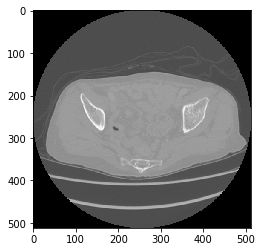

In [54]:
DICOM_finecut_image = dicom.read_file(dcm_finecut_path[0]).pixel_array
print(DICOM_finecut_image.shape)
plt.imshow(DICOM_finecut_image, cmap='gray')

For 55-cut images, some information is missing. Need to set `force=True` to read

In [47]:
dcm_55_path = glob.glob('/home/d/pancreas/new_label_data/000133/PC15/scans/*.dcm')
print('Reading the file', dcm_55_path[0])
dicom.read_file(dcm_55_path[0], force=True)

Reading the file /home/d/pancreas/new_label_data/000133/PC15/scans/1.3.12.2.1107.5.1.4.66765.30000016041201030368700018249_S3.I112.dcm


(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.1.4.66765.30000016041201030368700019894
(0008, 0020) Study Date                          DA: '20160412'
(0008, 0021) Series Date                         DA: '20160412'
(0008, 0022) Acquisition Date                    DA: '20160412'
(0008, 0023) Content Date                        DA: '20160412'
(0008, 002a) Acquisition DateTime                DT: '20160412103453.302000'
(0008, 0030) Study Time                          TM: '103033.694000'
(0008, 0031) Series Time                         TM: '103519.979000'
(0008, 0032) Acquisition Time                    TM: '103453.302000'
(0008, 0033) Content Time                        TM: '103453.302000'
(0008, 0050) Accession Number                

We will get error if we try to get the image direct from 55-cut DICOM

In [48]:
DICOM_55_image = dicom.read_file(dcm_55_path[0]).pixel_array
print(DICOM_55_image.shape)
plt.imshow(DICOM_55_image, cmap='gray')

InvalidDicomError: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.

Somehow you have to set the `TransferSyntaxUID` to let it work

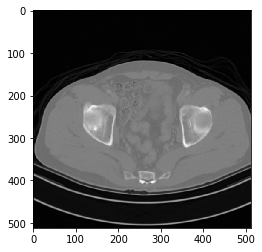

In [56]:
sample_scan = dicom.read_file(dcm_55_path[0], force=True)
sample_scan.file_meta.TransferSyntaxUID = dicom.uid.ImplicitVRLittleEndian
DICOM_55_image = sample_scan.pixel_array
plt.imshow(DICOM_55_image, cmap='gray')

## 3 Normalization of box data

In [13]:
img_path = '/home/d/pancreas/new_box_data/PC30/ctscan.npy'
pan_path = img_path.replace('ctscan', 'pancreas')
les_path = img_path.replace('ctscan', 'lesion')

sampleCTimg = np.load(img_path)
samplePancreas = np.load(pan_path)
sampleLesion = np.load(les_path)

print('Example data path:', img_path)
print(sampleCTimg.shape, samplePancreas.shape, sampleLesion.shape)

Example data path: /home/d/pancreas/new_box_data/PC30/ctscan.npy
(178, 101, 18) (178, 101, 18) (178, 101, 18)


In [14]:
sampleCTimg_clip = np.clip(sampleCTimg, -150, 250)

In [32]:
norm1 = sampleCTimg_clip / np.linalg.norm(sampleCTimg_clip)
norm2 = (sampleCTimg_clip - np.min(sampleCTimg_clip)) / (np.max(sampleCTimg_clip)-np.min(sampleCTimg_clip))

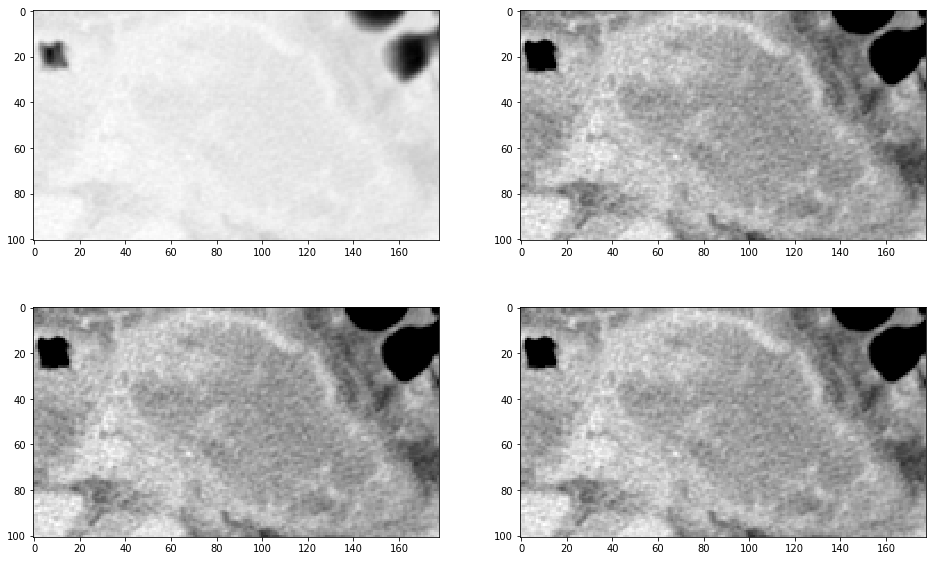

In [33]:
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
plt.imshow(sampleCTimg[:,:,10].T, cmap='gray')
plt.subplot(2,2,2)
plt.imshow(sampleCTimg_clip[:,:,10].T, cmap='gray')
plt.subplot(2,2,3)
plt.imshow(norm1[:,:,10].T, cmap='gray')
plt.subplot(2,2,4)
plt.imshow(norm2[:,:,10].T, cmap='gray')

In [34]:
print(np.max(sampleCTimg_clip), np.min(sampleCTimg_clip))
print(np.max(norm1), np.min(norm1), np.mean(norm1))
print(np.max(norm2), np.min(norm2), np.mean(norm2))

250 -150
0.007511476577347324 -0.004506885946408395 0.0007564276312644044
1.0 0.0 0.4379393255336769


## 4 Data distribution for patch data

In [4]:
pancreas_path = '/home/u/sonic81518/project/pancreas/patch_data/p13l8/train/pancreas/'
lesion_path = '/home/u/sonic81518/project/pancreas/patch_data/p13l8/train/lesion/'

In [6]:
pancreas = glob.glob(pancreas_path + '*.npy')
lesions = glob.glob(lesion_path + '*.npy') 

In [13]:
ID = []
for pancrea in pancreas:
    ID.append(ntpath.basename(pancrea).split('_')[0])
for lesion in lesions:
    ID.append(ntpath.basename(lesion).split('_')[0])    

In [20]:
name_list = []
pancreas_count = []
lesion_count = []
for index in set(ID):
    name_list.append(index)
    pancreas_count.append(len(glob.glob(pancreas_path + index + '*.npy')))
    lesion_count.append(len(glob.glob(lesion_path + index + '*.npy')))

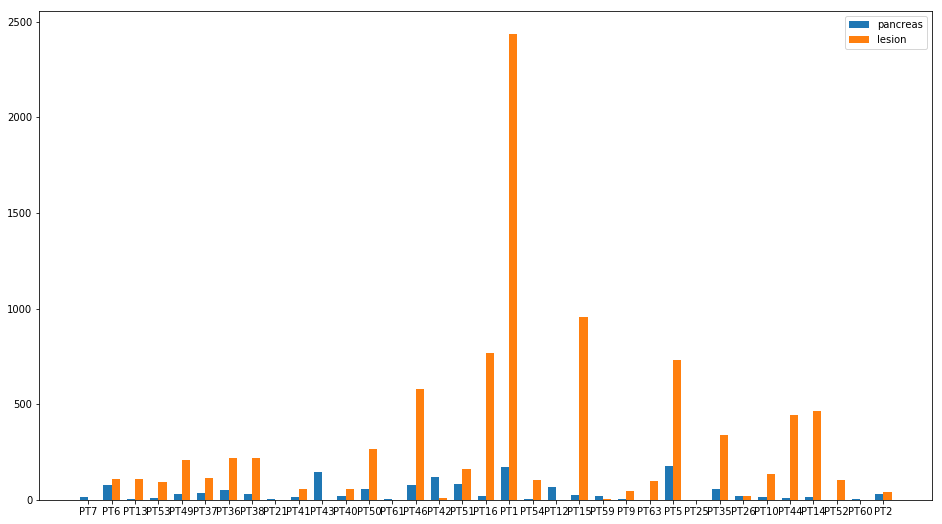

In [44]:
x = list(range(len(name_list)))
ind = np.arange(len(x))
width = 0.35

# fig, ax = plt.subplots()
# rects1 = ax.bar(ind - width/2, men_means, width, yerr=men_std,
#                 color='SkyBlue', label='Men')
# rects2 = ax.bar(ind + width/2, women_means, width, yerr=women_std,
#                 color='IndianRed', label='Women')



# plt.figure(figsize=(16, 9))
fig, ax = plt.subplots(figsize=(16, 9))

ax.bar(ind-width/2, pancreas_count, width = width, label='pancreas')
#for i in range(len(x)):
#    x[i] = x[i] + width
ax.bar(ind+width/2, lesion_count, width = width, label='lesion')

ax.set_xticks(ind)
ax.set_xticklabels(name_list)

plt.legend()
plt.show()


In [29]:
ind

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [30]:
ind-width/2

array([-0.175,  0.825,  1.825,  2.825,  3.825,  4.825,  5.825,  6.825,
        7.825,  8.825,  9.825, 10.825, 11.825, 12.825, 13.825, 14.825,
       15.825, 16.825, 17.825, 18.825, 19.825, 20.825, 21.825, 22.825,
       23.825, 24.825, 25.825, 26.825, 27.825, 28.825, 29.825, 30.825,
       31.825, 32.825, 33.825])

In [45]:
from random import shuffle

In [58]:
for index in set(ID):
    lesion_list = glob.glob(lesion_path + index + '*.npy')
    print(len(lesion_list))
    if len(lesion_list) > 250:
        shuffle(lesion_list)
        for file in lesion_list[250:]:
            os.remove(file)
    else:
        continue

0
97
109
92
209
115
217
216
0
54
0
57
264
0
580
10
160
770
1916
104
0
117
4
47
96
716
0
337
18
15
445
70
38
1
40


In [59]:
name_list = []
pancreas_count = []
lesion_count = []
for index in set(ID):
    name_list.append(index)
    pancreas_count.append(len(glob.glob(pancreas_path + index + '*.npy')))
    lesion_count.append(len(glob.glob(lesion_path + index + '*.npy')))

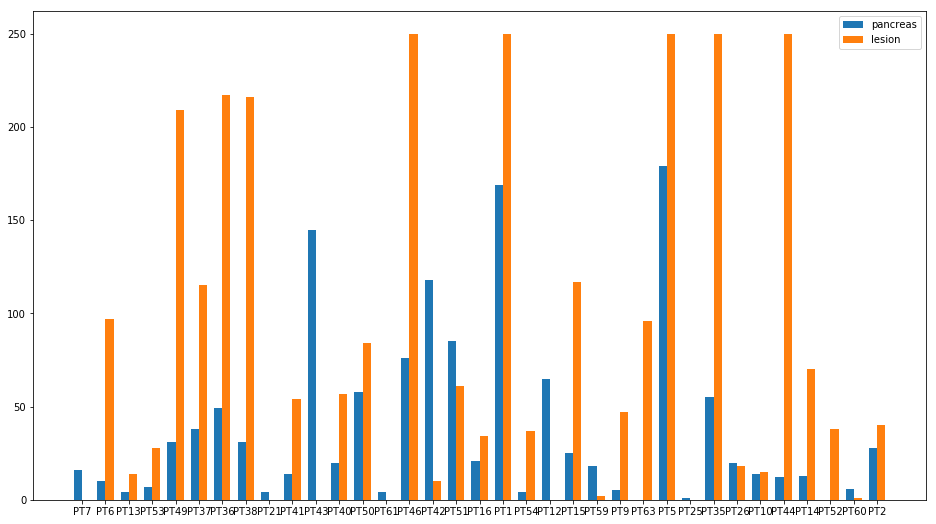

In [60]:
x = list(range(len(name_list)))
ind = np.arange(len(x))
width = 0.35

# fig, ax = plt.subplots()
# rects1 = ax.bar(ind - width/2, men_means, width, yerr=men_std,
#                 color='SkyBlue', label='Men')
# rects2 = ax.bar(ind + width/2, women_means, width, yerr=women_std,
#                 color='IndianRed', label='Women')



# plt.figure(figsize=(16, 9))
fig, ax = plt.subplots(figsize=(16, 9))

ax.bar(ind-width/2, pancreas_count, width = width, label='pancreas')
#for i in range(len(x)):
#    x[i] = x[i] + width
ax.bar(ind+width/2, lesion_count, width = width, label='lesion')

ax.set_xticks(ind)
ax.set_xticklabels(name_list)

plt.legend()
plt.show()

## 5 A phase & V phase
An example for seperating A phase and V phase

In [10]:
dcm_path = glob.glob('/home/d/pancreas/raw_data/tumor/000024/20171223/*/*.dcm')

In [11]:
len(dcm_path)

570

In [18]:
time_list = []
for path in dcm_path:
    time_list.append(str(dicom.read_file(path)[0x0008, 0x0032].value))

In [19]:
set(time_list)

{'191015.108329', '191101.185760'}

In [35]:
for num in set(time_list):
    print('There are', time_list.count(num), 'dicom files for time', num)

There are 369 dicom files for time 191101.185760
There are 201 dicom files for time 191015.108329


In [60]:
dcm_path2 = glob.glob('/home/d/pancreas/raw_data/tumor/000133/20170926/*/*.dcm')

In [61]:
len(dcm_path2)

935

In [62]:
time_list2 = []
for path in dcm_path2:
    time_list2.append(str(dicom.read_file(path)[0x0008, 0x0032].value))

In [63]:
len(set(time_list2))

935

In [50]:
for num in set(time_list2):
    print('There are', time_list2.count(num), 'dicom files for time', num)

There are 197 dicom files for time 151039.996537
There are 365 dicom files for time 151135.441968
